# GEDI Level 2B Vertical Plant Profiles

The GEDI Level 2B product provides vertical cover, plant area index (PAI) and plant area volume density (PAVD) profiles at a vertical resolution of 5 m. This notebook shows how to retrieve the directional gap probability (Pgap) profile from the Level 2B product using GEDIPy, compute these vertical profile metrics at the vertical resolution of the original Level 1B waveform, and then visualize them.

In [1]:
import numpy
import pandas

import matplotlib.pyplot as plt
import ipywidgets

from gedipy import h5io

## A function to recompute vertical profiles
We need datasets from the Level 2B file to compute the zenith angle of laser shot and also ancillary metrics including the RossG coefficent (canopy element projection function) and Omega coefficient (clumping factor)

In [2]:
def get_vertical_profiles(pgap_theta_z, height, local_beam_elevation, rossg, omega):
    cos_zenith = numpy.abs( numpy.sin(local_beam_elevation) )
    cover_z = cos_zenith * (1.0 - pgap_theta_z)
    pai_z = -(1.0 / (rossg * omega)) * numpy.log(pgap_theta_z) * cos_zenith
    pavd_z = -numpy.gradient(pai_z, height)
    return cover_z, pai_z, pavd_z

## Open the H5 file
We select one of the power beams for this example

In [3]:
l2b_f = h5io.GEDIH5File('GEDI02_B_2019121233316_O02176_T04876_02_001_01.h5')
l2b_f.open()
beam = 'BEAM1011'
l2b_f.beams

['BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011']

## Read all the profiles for one beam
This remaps the 1D pgap_theta_z array to a 2D M x N array, where M is the number Pgap profiles bins and N is the number of GEDI shots

In [4]:
pgap_theta_z, height = l2b_f.read_pgap_theta_z(beam, height=True)

## Read waveform and ancillary metrics

In [5]:
# Only read what we need - note that rh100 is in units of cm
dataset_list = ['shot_number', 'rh100', 'omega', 'rossg', 'l2b_quality_flag', 
                'pgap_theta_error', 'geolocation/local_beam_elevation']
l2b_data = l2b_f.read_shots(beam, dataset_list=dataset_list)

# Get the index of all quality shots
idx, = numpy.nonzero(l2b_data['l2b_quality_flag'])

# Use pandas to make it print nice
pandas.DataFrame(l2b_data)

,shot_number,rh100,omega,rossg,l2b_quality_flag,pgap_theta_error,local_beam_elevation
0,21761122500000001,509,1.0,0.5,1,0.000130,1.552016
1,21761122700000002,403,1.0,0.5,1,0.000204,1.552016
2,21761122900000003,377,1.0,0.5,1,0.000104,1.552016
3,21761123100000004,299,1.0,0.5,0,0.000123,1.552016
4,21761123300000005,302,1.0,0.5,1,0.000088,1.552016
...,...,...,...,...,...,...,...
342568,21761121400342569,0,1.0,0.5,0,-9999.000000,1.554001
342569,21761121600342570,0,1.0,0.5,0,-9999.000000,1.554001
342570,21761121800342571,0,1.0,0.5,0,-9999.000000,1.554001
342571,21761122000342572,1060,1.0,0.5,0,0.022081,1.554001


## Plot example vertical plant profiles

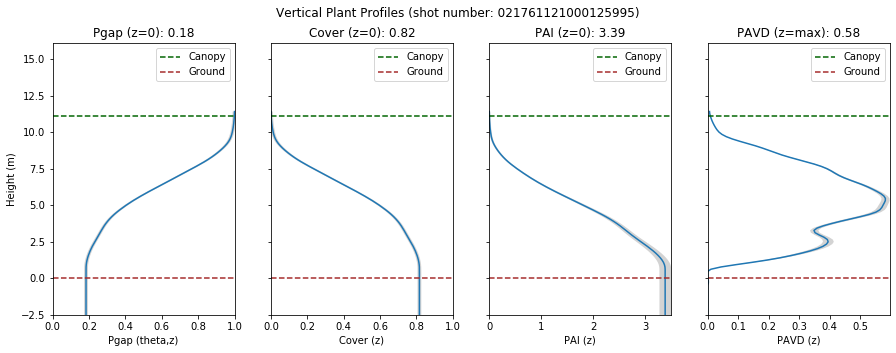

In [12]:
%matplotlib inline

def update(index=56192):
    i = idx[index]
    
    err = l2b_data['pgap_theta_error'][i]
    rh100 = l2b_data['rh100'][i] / 100
    
    cover_z, pai_z, pavd_z = get_vertical_profiles(pgap_theta_z[:,i], height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z0, pai_z0, pavd_z0 = get_vertical_profiles(pgap_theta_z[:,i]-err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
    cover_z1, pai_z1, pavd_z1 = get_vertical_profiles(pgap_theta_z[:,i]+err, height[:,i], 
        l2b_data['local_beam_elevation'][i], l2b_data['rossg'][i], l2b_data['omega'][i])
        
    fig,axs = plt.subplots(1, 4, figsize=(15, 5), sharey=True)
    
    axs[0].fill_betweenx(height[:,i], pgap_theta_z[:,i]-err, pgap_theta_z[:,i]+err, facecolor='lightgrey')
    axs[0].plot(pgap_theta_z[:,i], height[:,i])
    axs[0].axhline(y=rh100, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[0].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[0].legend(loc='upper right')
    
    axs[1].fill_betweenx(height[:,i], cover_z0, cover_z1, facecolor='lightgrey')
    axs[1].plot(cover_z, height[:,i])
    axs[1].axhline(y=rh100, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[1].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[1].legend(loc='upper right')
    
    axs[2].fill_betweenx(height[:,i], pai_z0, pai_z1, facecolor='lightgrey')
    axs[2].plot(pai_z, height[:,i])
    axs[2].axhline(y=rh100, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[2].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[2].legend(loc='upper right')
    
    axs[3].fill_betweenx(height[:,i], pavd_z0, pavd_z1, facecolor='lightgrey')
    axs[3].plot(pavd_z, height[:,i])
    axs[3].axhline(y=rh100, color='darkgreen', linestyle='dashed', label='Canopy')
    axs[3].axhline(y=0, color='brown', linestyle='dashed', label='Ground')
    axs[3].legend(loc='upper right')

    axs[0].set(xlim=(0, 1), ylim=(-2.5, rh100+5), 
               title='Pgap (z=0): {:.2f}'.format(pgap_theta_z[-1,i]),
               xlabel='Pgap (theta,z)', ylabel='Height (m)')
    axs[1].set(xlim=(0, 1), xlabel='Cover (z)',
               title='Cover (z=0): {:.2f}'.format(cover_z[-1]))
    axs[2].set(xlim=(0, max(1,pai_z0[-1])), xlabel='PAI (z)',
               title='PAI (z=0): {:.2f}'.format(pai_z[-1]))
    axs[3].set(xlim=(0, max(0.1,max(pavd_z0))), xlabel='PAVD (z)',
               title='PAVD (z=max): {:.2f}'.format(max(pavd_z)))
    
    fig.suptitle('Vertical Plant Profiles (shot number: {:018d})'.format(l2b_data['shot_number'][i]))   
    fig.canvas.draw()
    
update()

## Generate an interactive plot

In [11]:
nrecords = numpy.count_nonzero(l2b_data['l2b_quality_flag'])
ipywidgets.interact(update, index=ipywidgets.IntSlider(min=0, max=nrecords-1, step=1, 
                                                       value=56192, continuous_update=False))

interactive(children=(IntSlider(value=56192, continuous_update=False, description='index', max=136123), Output…

<function __main__.update(index=56192)>